In [8]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv
from sklearn.model_selection import train_test_split
import math


In [9]:
model_name = "model_large"
img_width = 200
img_height = 66
img_channels = 3
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)


In [10]:
import requests 
import os
import zipfile

dataset_dir = "dataset"
dataset_zipfile = 'Dataset.zip'
RPI_IP=None # '10.104.124.194'  # replace this with the IP address of your raspberry pi 
RunningInCOLAB = 'google.colab' in str(get_ipython())
force_unzip = False

if RunningInCOLAB: 
    print("in colab")
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
else:
    print ("not in colab")
    if RPI_IP is not None:
        URL="http://"+RPI_IP+":8000/"+dataset_zipfile
        filename=URL.split('/')[-1]
        r = requests.get(URL)
        open(filename, 'wb').write(r.content)

if not os.path.isfile(dataset_zipfile):
    default_dataset_URL = "https://raw.githubusercontent.com/Karenw1004/Deeppicar-v3/main/Dataset.zip"
    print ("No existing dataset. download from ", default_dataset_URL)
    !wget --no-check-certificate --no-clobber {default_dataset_URL}

if not os.path.isdir(dataset_dir) or force_unzip==True:
    print ('unzip %s into %s folder' % (dataset_zipfile, dataset_dir))
    zip_ref = zipfile.ZipFile(dataset_zipfile)
    zip_ref.extractall(dataset_dir)

not in colab


In [11]:
from keras import layers

model = tf.keras.Sequential()
model.add(layers.Conv2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(img_height,img_width,img_channels)))
model.add(layers.Conv2D(36, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(48, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

In [14]:
# Train/test data lists
imgs = []
vals = []

import glob
for vid_file_path in glob.iglob(f'{dataset_dir}/*.avi'):
    csv_file_path = vid_file_path.replace('video', 'key').replace('avi', 'csv')
    print(vid_file_path, csv_file_path)

    vid = cv2.VideoCapture(vid_file_path)
    ret,img = vid.read()
    while(ret):
        # Convert to grayscale and readd channel dimension
        if img_channels == 1:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (img_width, img_height))
            img = np.reshape(img, (img_height, img_width, img_channels))
        # For RGB, just need to resize image
        else:
            img = cv2.resize(img, (img_width, img_height))
        img = img / 255.
        imgs.append(img)
        ret,img = vid.read()
    df = read_csv(csv_file_path)
    temp = np.asarray(df["wheel"].values)
    vals.extend(temp)
    # print(len(imgs), len(vals))    

# Convert lists to numpy arrays and ensure they are of equal length    
imgs = np.asarray(imgs)  # input images
vals = np.asarray(vals)  # steering angles
assert len(imgs) == len(vals)
print("Loaded {} smaples".format(len(imgs)))

dataset\out-video-0.avi dataset\out-key-0.csv
dataset\out-video-1.avi dataset\out-key-1.csv
dataset\out-video-2.avi dataset\out-key-2.csv
dataset\out-video-3.avi dataset\out-key-3.csv
dataset\out-video-4.avi dataset\out-key-4.csv
dataset\out-video-5.avi dataset\out-key-5.csv
dataset\out-video-6.avi dataset\out-key-6.csv
dataset\out-video-7.avi dataset\out-key-7.csv
dataset\out-video-9.avi dataset\out-key-9.csv
Loaded 9000 smaples


In [15]:
# Split the dataset for train and test 
print("Train/Test")
x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.25)

Train/Test


In [16]:
#print(x_train[0])
print ("Model compile")
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss='mse', metrics=['mae'])

Model compile


Model fit
Epoch 1/10
68/68 [==============================] - 40s 547ms/step - loss: 0.1235 - mae: 0.3017 - val_loss: 0.0956 - val_mae: 0.2574
Epoch 2/10
68/68 [==============================] - 35s 510ms/step - loss: 0.0851 - mae: 0.2287 - val_loss: 0.0840 - val_mae: 0.2312
Epoch 3/10
68/68 [==============================] - 33s 479ms/step - loss: 0.0770 - mae: 0.2130 - val_loss: 0.0748 - val_mae: 0.2149
Epoch 4/10
68/68 [==============================] - 31s 459ms/step - loss: 0.0683 - mae: 0.2087 - val_loss: 0.0672 - val_mae: 0.2088
Epoch 5/10
68/68 [==============================] - 31s 457ms/step - loss: 0.0630 - mae: 0.1994 - val_loss: 0.0651 - val_mae: 0.2062
Epoch 6/10
68/68 [==============================] - 31s 459ms/step - loss: 0.0600 - mae: 0.1938 - val_loss: 0.0622 - val_mae: 0.1971
Epoch 7/10
68/68 [==============================] - 32s 467ms/step - loss: 0.0569 - mae: 0.1872 - val_loss: 0.0594 - val_mae: 0.1894
Epoch 8/10
68/68 [==============================] - 30s 446

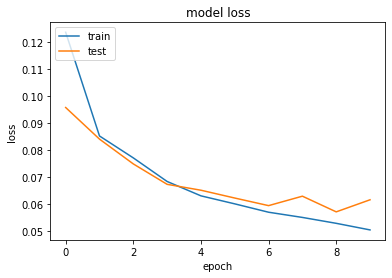

In [17]:
print ("Model fit")
history = model.fit(x_train, y_train, batch_size=100,
                    epochs=10, validation_data=(x_test, y_test))

# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# Helper functions for evaluating model accuracy
def rad2deg(rad):
  return 180.0 * rad / math.pi
def get_action(angle_rad):
  degree = rad2deg(angle_rad)
  if degree < 15 and degree > -15:
    return "center"
  elif degree >= 15:
    return "right" 
  elif degree <-15:
    return "left"

In [19]:
pred = model.predict(x_test)
pred = np.array(list(map(get_action, pred)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred == ground))

Accuracy is 0.713


In [20]:
# Save both the Keras and TFLite models      
print("Model Save")                  
model.save(model_file+".h5")

print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]

quantized_tflite_model = converter.convert()

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

print (model_file+".tflite is saved. copy this file to the robot")

Model Save
TFLite Model
INFO:tensorflow:Assets written to: C:\Users\heechul\AppData\Local\Temp\tmpovscr0_y\assets
